## Code to work with ATM data along the flowline of Zachariae Isstrom

**by Jukes Liu**

**June 2019 ICESat-2 Hackweek**


In [1]:
#IMPORT PACKAGES
import os
import glob
import pandas as pd
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
import pyproj

Read in ATM elevation CSV files into dataframes and each variable into 1D numpy arrays:

In [2]:
#get all the relevant csv files as a list and sort in order of the flight path
filelist = glob.glob("../data/*2018*.csv")
filelist.sort(reverse=True)
print(filelist)
#create an empty DataFrame to hold the stitched together ATM data along the profile
df_total = pd.DataFrame()

#for each csv file
for file in filelist:
    #print(file)
    #read the csv file into a pandas DataFrame
    csv_df = pd.read_csv(file, skiprows=9)
    
    #slice it to only keep Lat, Long, Ellipsoid Height
    df_slice = csv_df.loc[:, csv_df.keys()[1]: csv_df.keys()[3]]
    #print(df_slice)
    
    #concatenate (join) it to the df_total
    df_total = pd.concat([df_slice, df_total])

#check that we have all the data properly stitched together:
#print(df_total)

#Read latitude from DataFrame into 1D array
ATM_lat = df_total.loc[:, df_total.keys()[0]].values
#print(ATM_lat)

#Read longitude from DataFrame into 1D Array
ATM_long = df_total.loc[:, df_total.keys()[1]].values
#print(ATM_long)

#Read elevation from DataFrame into 1D Array
ATM_elev = df_total.loc[:, df_total.keys()[2]].values

#check the elevation data:
#for i in range(len(ATM_elev)):
    #print(i, ATM_elev[i])

['../data/ILATM2_20180418_134800_smooth_nadir3seg_50pt.csv', '../data/ILATM2_20180418_134700_smooth_nadir3seg_50pt.csv', '../data/ILATM2_20180418_134600_smooth_nadir3seg_50pt.csv', '../data/ILATM2_20180418_134500_smooth_nadir3seg_50pt.csv', '../data/ILATM2_20180418_134400_smooth_nadir3seg_50pt.csv', '../data/ILATM2_20180418_134300_smooth_nadir3seg_50pt.csv', '../data/ILATM2_20180418_134200_smooth_nadir3seg_50pt.csv', '../data/ILATM2_20180418_134100_smooth_nadir3seg_50pt.csv', '../data/ILATM2_20180418_134000_smooth_nadir3seg_50pt.csv', '../data/ILATM2_20180418_133900_smooth_nadir3seg_50pt.csv', '../data/ILATM2_20180418_133800_smooth_nadir3seg_50pt.csv', '../data/ILATM2_20180418_133700_smooth_nadir3seg_50pt.csv', '../data/ILATM2_20180418_133600_smooth_nadir3seg_50pt.csv', '../data/ILATM2_20180418_133500_smooth_nadir3seg_50pt.csv', '../data/ILATM2_20180418_133400_smooth_nadir3seg_50pt.csv', '../data/ILATM2_20180418_133300_smooth_nadir3seg_50pt.csv']


Reproject lat and long into Greenland Polar Stereo coordinates (ESPG: 3413)

In [3]:
#REPROJECT LAT LONG INTO GREENLAND POLAR STEREO(ESPG: 3413)

#Coordinate transformation function written by Fernando Paolo:
def transform_coord(proj1, proj2, x, y):
    """
    Transform coordinates from proj1 to proj2 (EPSG num).

    Example EPSG projs:
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    """
    # Set full EPSG projection strings
    proj1 = pyproj.Proj("+init=EPSG:"+str(proj1))
    proj2 = pyproj.Proj("+init=EPSG:"+str(proj2))
    return pyproj.transform(proj1, proj2, x, y)  # convert

#use the function to transform into Greenland Polar Stereo (PS_x, PS_y)
PS_coords = transform_coord(4326, 3413, ATM_long, ATM_lat)
PS_x = PS_coords[0]
PS_y = PS_coords[1]
print(PS_x)
print(PS_y)

[397913.47706814 397915.70409007 397917.94624422 ... 521563.18496156
 521506.26241972 521554.12880888]
[-1102425.77908309 -1102341.5766936  -1102257.36808201 ...
 -1084640.72154964 -1084535.5284331  -1084623.97262617]


In [ ]:
print(ATM_lat.min(), ATM_lat.max(),ATM_long.min()-360, ATM_long.max()-360)
print(PS_y.min(), PS_y.max(), PS_x.min()-360, PS_x.max()-360)
print( (PS_y.min() - PS_y.max())/1000, 
       (PS_x.min() - PS_x.max() )/1000 ) 
# print(filelist)

In [14]:
x = np.array([1, 2, 3, 4, 5, 6, 7, 9, 6, 5, 4, 2, 0, 1])
N_smooth = 251 # Number of points to use in a running average
# ref_x = np.convolve(x, np.ones((N_smooth,))/N_smooth, mode='same')
ref_x = np.convolve(PS_x, np.ones((N_smooth,))/N_smooth, mode='same')
ref_y = np.convolve(PS_y, np.ones((N_smooth,))/N_smooth, mode='same')
trim_factor = np.floor(N_smooth/2).astype('int')

ref_elev = ATM_elev[trim_factor:-trim_factor]
ref_x = ref_x[trim_factor:-trim_factor]
ref_y = ref_y[trim_factor:-trim_factor]

# x = x[trim_factor:-trim_factor]


In [ ]:
# For 2014
plt.plot((ATM_long))#, PS_y)
PS_x[6100:6200]
# plt.plot(PS_diffs, 'o')#PS_x, PS_y)
# PS_diffs
plt.xlim(6100, 6200)
# plt.ylim(510000, 530000)
# plt.ylim(340, 341)

## Look at the difference along track, between consecutive ATM points
Even with a 251 point running average, there's still too much back and forth wander in the points.  But it's much much better

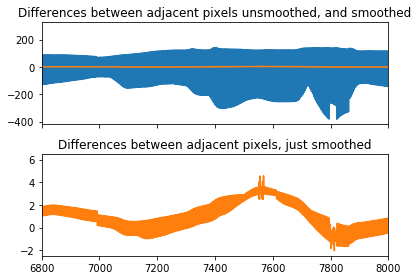

In [22]:
# For 2018
# Comment just this following line, with PS_y to see this
fig, ax = plt.subplots(2, sharex=True)
ax[0].plot(np.diff(PS_y))#, PS_y)
# plt.plot(np.diff(PS_y))#, PS_y)
ax[0].plot(np.diff(ref_y))#, PS_y)
ax[0].set_title('Differences between adjacent pixels unsmoothed, and smoothed');
ax[1].plot(np.diff(ref_y), color='C1')#, PS_y)
ax[1].set_title('Differences between adjacent pixels, just smoothed');


# PS_x[6100:6200]
# plt.plot(PS_diffs, 'o')#PS_x, PS_y)
# PS_diffs
# plt.xlim(6100, 6200)
ax[0].set_xlim(6800, 8000)
# plt.ylim(510000, 530000)
# plt.ylim(340, 341)
plt.tight_layout()

Calculate distance along the flowline:

In [ ]:
print(np.diff(ref_x[0:50]))
print(np.diff(PS_x[0:50]))
dist_along[0:20]
# np.diff(ATM_long[0:2])

In [ ]:
trim_factor
x

In [ ]:
print(PS_y)
print(ref_y[0:20])

#### Tim replaced most of this cell with the lines below that do the same thing

In [23]:
#create an empty array to contain the distance along flow 
# dist_along = np.empty(len(ATM_lat), dtype=float)

# PS_diffs = np.sqrt( np.diff(PS_x)**2 + np.diff(PS_y)**2 ) # m
PS_diffs = np.sqrt( np.diff(ref_x)**2 + np.diff(ref_y)**2 ) # m
dist_along = np.cumsum(PS_diffs)
dist_along = np.append(0, dist_along)

# #for each lat-long point:
# for i in range(len(ATM_lat)):
#     #for the first point, set distance along flow to 0 m
#     if i == 0:
#         dist_along[i] = 0.0
    
#     #for all other subsequent points:
#     else:
#         #calculate distance from the last point
#         #in North PS, no conversion needed
#         x_diff = PS_x[i] - PS_x[i-1]
#         y_diff = PS_y[i] - PS_y[i-1]
#         #print(x_diff, y_diff)
                
#         #calculate distance from the previous point using the distance formula:    
#         #in km using PS
#         dist_last = math.sqrt(((x_diff/1000)**2)+((y_diff/1000)**2))
#         #print(dist_last)
        
#         #add it to the previous distance along the track to get the cumulative distance
#         dist_along[i] = dist_last + dist_along[i-1]

#     #check the array of distance along the track in meters:
print(dist_along, ATM_elev)

[0.00000000e+00 8.62781793e+00 1.73882777e+01 ... 1.25789313e+05
 1.25797268e+05 1.25805122e+05] [891.4235 891.6056 891.7156 ...  28.7702  28.7218  28.7838]


Plot the elevation profile along the flowline:

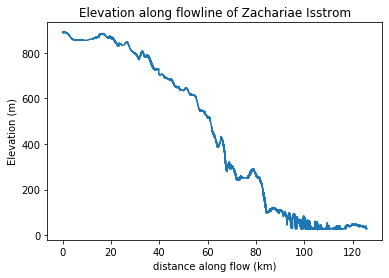

In [24]:
# %matplotlib widget

# plt.plot(dist_along/1000, ATM_elev)
plt.plot(dist_along/1000, ref_elev)
plt.ylabel('Elevation (m)')
plt.xlabel('distance along flow (km)')
plt.title('Elevation along flowline of Zachariae Isstrom')
plt.show()

Plot the horizontal footprint with elevation color coded:

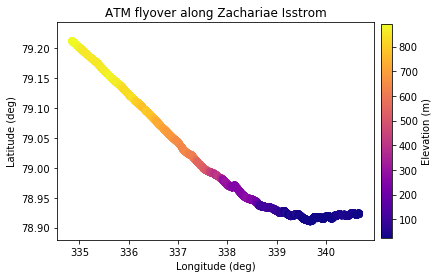

In [25]:
# %matplotlib widget

plt.scatter(ATM_long, ATM_lat, c=ATM_elev,cmap='plasma')
plt.ylabel('Latitude (deg)')
plt.xlabel('Longitude (deg)')
plt.title('ATM flyover along Zachariae Isstrom')
plt.colorbar(fraction=0.0320, pad=0.02, label='Elevation (m)')
plt.show()

Final data extracted into arrays:
+ ATM_long: longitude of elev points
+ ATM_lat: latitude of elev points
+ PS_x: x-coords of elev points in Greenland Polar Stereo
+ PS_y: y-coords of elev points in Greenland Polar Stereo
+ ATM_elev: elevation points with z in meters
+ dist_along: distance along the flowline in km

...and recombined into a dataframe:

In [ ]:
variables = [ATM_long, ATM_lat, PS_x, PS_y, ATM_elev, dist_along]
indices = ['ATM_long', "ATM_lat", "PS_x", "PS_y", "ATM_elev", "dist_along"]

#create DataFrame from these variables
final_data = pd.DataFrame(variables)
final_data = final_data.transpose()
final_data.columns = indices
print(final_data.head())

In [ ]:
final_data.to_csv('atmZach04_18_19.csv',index=False)